In [1]:
%load_ext autoreload

In [27]:
import scanpy as sc
import lightning.pytorch as pl
import scanpy as sc
from data import AdataDataModule
from models import MLPAutoEncoder
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [3]:
%autoreload 2
from train import train

In [4]:
DATA_PATH = '/lustre/groups/ml01/workspace/till.richter/scTab/cellxgene_train_dataset_HLCA_adata.h5ad'

In [5]:
adata = sc.read_h5ad(DATA_PATH)
adata.shape

(540732, 19331)

In [6]:
# Custom callback to log losses
class LossLogger(pl.Callback):
    def __init__(self):
        self.train_losses = []
        self.val_losses = []

    def on_train_epoch_end(self, trainer, pl_module):
        train_loss = trainer.callback_metrics.get("train_loss")
        val_loss = trainer.callback_metrics.get("val_loss")

        if train_loss is not None:
            self.train_losses.append(train_loss.item())
        if val_loss is not None:
            self.val_losses.append(val_loss.item())
        
        # Print losses every epoch
        print(f"Epoch {trainer.current_epoch}: train_loss = {train_loss}, val_loss = {val_loss}")

def train(
    adata,
    units_encoder=[512, 256, 128],
    units_decoder=[128, 256, 512],
    batch_size=2048,
    masking_strategy="random",
    masking_rate=0.5,
    max_epochs=100,
):
    """
    Train the MLPAutoEncoder model using the provided data and log the losses.

    Args:
        adata (AnnData): The input data for training.
        units_encoder (list, optional): List of integers specifying the number of units in each encoder layer. Defaults to [512, 256, 128].
        units_decoder (list, optional): List of integers specifying the number of units in each decoder layer. Defaults to [128, 256, 512].
        batch_size (int, optional): The batch size for training. Defaults to 2048.
        masking_strategy (str, optional): The masking strategy to be used during training. Defaults to "random".
        masking_rate (float, optional): The rate of masking to be applied during training. Defaults to 0.5.
        max_epochs (int, optional): The maximum number of epochs for training. Defaults to 100.

    Returns:
        model: The trained MLPAutoEncoder model.
        LossLogger: The logger containing train and val losses.
    """
    model = MLPAutoEncoder(
        gene_dim=adata.shape[1],
        units_encoder=units_encoder,
        units_decoder=units_decoder,
        batch_size=batch_size,
        masking_strategy=masking_strategy,
        masking_rate=masking_rate,
    )
    datamodule = AdataDataModule(adata=adata, batch_size=batch_size)

    logger = LossLogger()

    trainer = pl.Trainer(
        max_epochs=max_epochs,
        callbacks=[logger],
    )

    trainer.fit(model, datamodule)
    
    return model, logger

In [7]:
# Load the data
data_path = "/lustre/groups/ml01/workspace/till.richter/patient_rep/combat_processed.h5ad"
adata = sc.read_h5ad(data_path)

# Train the model
model, logger = train(
    adata,
    units_encoder=[512, 256, 128],
    units_decoder=[128, 256, 512],
    batch_size=2048,
    masking_strategy="random",
    masking_rate=0.5,
    max_epochs=10
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-PCIE-40GB MIG 3g.20gb') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-f0137d16-692e-5a8f-8010-04855d7d97d5]

  | Name          | Type             | Params
---------------------------------------------------
0 | train_metrics | MetricCollection | 0     
1 | val_metrics   | MetricCollection | 0     
2 | test_metrics  | MetricCollection | 0     
3 | encoder       | MLP              | 1.7 M 
4 | decoder       | Sequential       | 1.7 M 
---------------------------------------------------
3.4 M     Tr

Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Epoch 0: train_loss = 0.09656521677970886, val_loss = 0.08881682902574539


Validation: |                                                                                                 …

Epoch 1: train_loss = 0.08807653188705444, val_loss = 0.08738275617361069


Validation: |                                                                                                 …

Epoch 2: train_loss = 0.08734464645385742, val_loss = 0.08708588033914566


Validation: |                                                                                                 …

Epoch 3: train_loss = 0.08707394450902939, val_loss = 0.08679646253585815


Validation: |                                                                                                 …

Epoch 4: train_loss = 0.08693169057369232, val_loss = 0.08666258305311203


Validation: |                                                                                                 …

Epoch 5: train_loss = 0.08680412173271179, val_loss = 0.08655509352684021


Validation: |                                                                                                 …

Epoch 6: train_loss = 0.08674044162034988, val_loss = 0.0865163803100586


Validation: |                                                                                                 …

Epoch 7: train_loss = 0.0866648405790329, val_loss = 0.08651045709848404


Validation: |                                                                                                 …

Epoch 8: train_loss = 0.08661724627017975, val_loss = 0.08640226721763611


Validation: |                                                                                                 …

Epoch 9: train_loss = 0.08657313138246536, val_loss = 0.08645162731409073


`Trainer.fit` stopped: `max_epochs=10` reached.


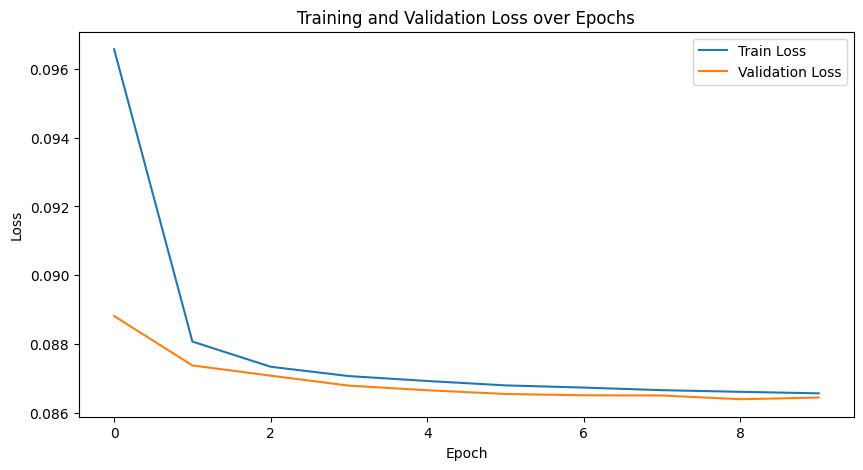

In [8]:
# Plot the loss curves
epochs = np.arange(len(logger.train_losses))
plt.figure(figsize=(10, 5))
plt.plot(epochs, logger.train_losses, label='Train Loss')
plt.plot(epochs, logger.val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [9]:
adata = adata[:1000]

In [13]:
embeddings = model.encoder(torch.tensor(adata.X.todense()).float()).detach().numpy()

# Create UMAP with Scanpy
adata.obsm['X_emb'] = embeddings
sc.pp.neighbors(adata, use_rep='X_emb')
sc.tl.umap(adata)

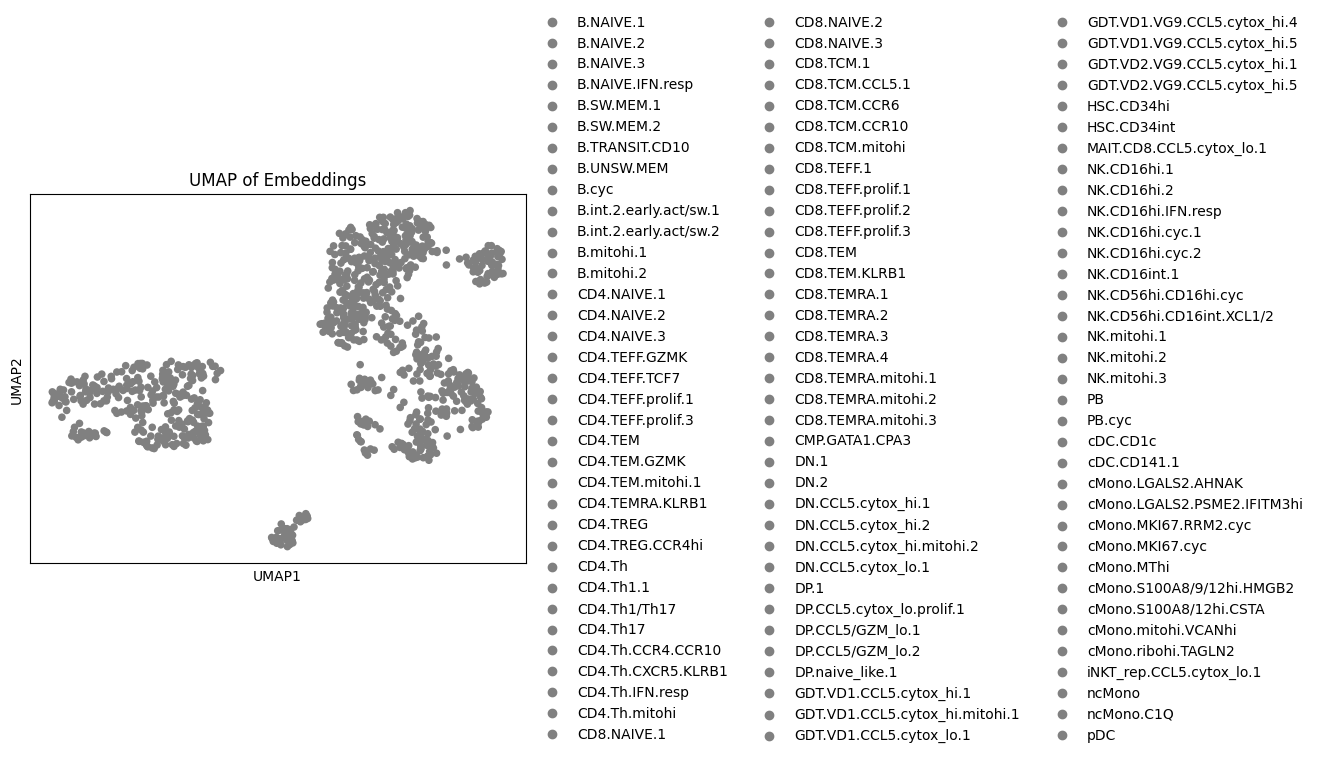

In [16]:
# Plot UMAP
sc.pl.umap(adata, color='Annotation_cluster_name', title='UMAP of Embeddings')

In [25]:
# Reconstruct the features
_, reconstructed = model(torch.tensor(adata.X.todense()).float())
reconstructed = reconstructed.detach().numpy()

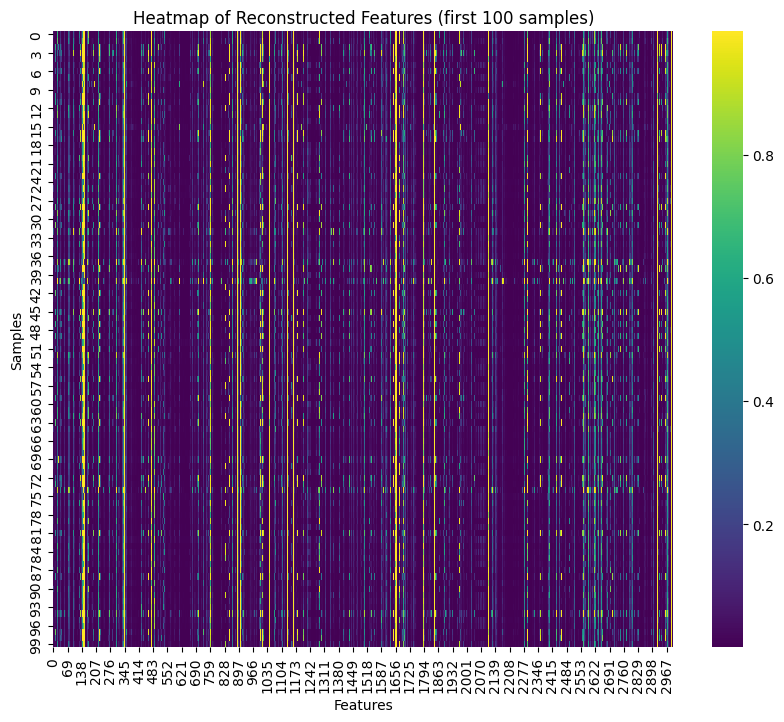

In [28]:
# Plot heatmap of reconstructed features
plt.figure(figsize=(10, 8))
sns.heatmap(reconstructed[:100], cmap='viridis')
plt.title('Heatmap of Reconstructed Features (first 100 samples)')
plt.xlabel('Features')
plt.ylabel('Samples')
plt.show()